In [1]:
import pandas as pd
import numpy as np
import ast
import cv2
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

In [2]:
# ===== CONFIG =====
LOG_PATH = "detections_log_front_room_2.csv"
VIDEO_PATH = r"Vid_test\front_room_2.mp4"
FRAME_WIDTH = 1280
FRAME_HEIGHT = 720

In [3]:
# ===== อ่าน CSV และดึงพิกัด =====
df = pd.read_csv(LOG_PATH, on_bad_lines='skip')

In [4]:
# ฟังก์ชันแปลง string -> tuple -> pixel coords
def parse_xy(xy_str):
    try:
        xy = ast.literal_eval(str(xy_str))
        if isinstance(xy, (list, tuple)) and len(xy) == 2:
            cx = float(xy[0]) * FRAME_WIDTH if float(xy[0]) <= 1 else float(xy[0])
            cy = float(xy[1]) * FRAME_HEIGHT if float(xy[1]) <= 1 else float(xy[1])
            return cx, cy
    except:
        pass
    return None

In [5]:
xy_cols = [col for col in df.columns if "_xy" in col]
points = []
for _, row in df.iterrows():
    for col in xy_cols:
        coords = parse_xy(row[col])
        if coords:
            points.append(coords)

points = np.array(points, dtype=float)
points = points[~np.isnan(points).any(axis=1)]
if len(points) < 2:
    raise ValueError(f"ต้องการอย่างน้อย 2 จุด แต่พบ {len(points)}")

In [6]:
# ===== คำนวณ KDE =====
xy = np.vstack([points[:, 0], points[:, 1]])
kde = gaussian_kde(xy)

In [7]:
# ใช้ grid resolution เท่ากันทั้งสองภาพ
xi, yi = np.mgrid[0:FRAME_WIDTH:500j, 0:FRAME_HEIGHT:500j]
coords = np.vstack([xi.flatten(), yi.flatten()])
density = kde(coords).reshape(xi.shape)

In [8]:
# หาค่า min/max สำหรับ fix scale
vmin, vmax = density.min(), density.max()

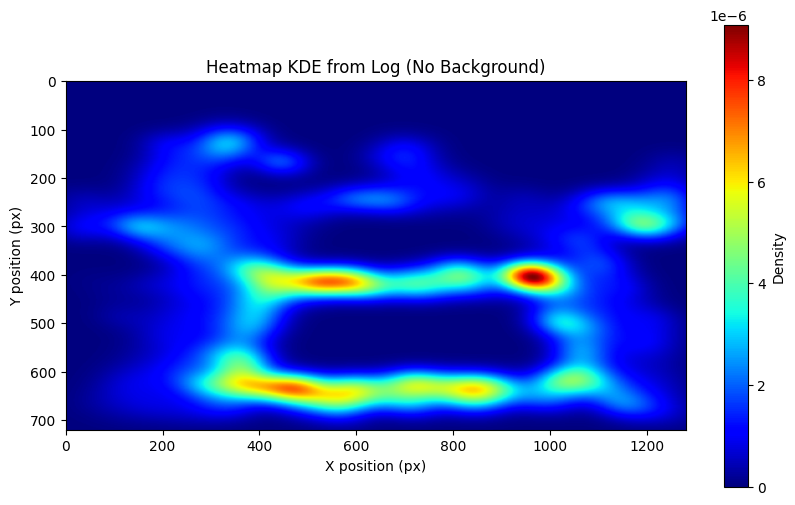

In [9]:
# ===== 1) Plot Heatmap KDE without background =====
plt.figure(figsize=(10, 6))
plt.imshow(
    density.T,
    cmap="jet",
    origin="lower",
    extent=[0, FRAME_WIDTH, 0, FRAME_HEIGHT],
    vmin=vmin, vmax=vmax
)
plt.colorbar(label="Density")
plt.gca().invert_yaxis()
plt.title("Heatmap KDE from Log (No Background)")
plt.xlabel("X position (px)")
plt.ylabel("Y position (px)")
plt.savefig("heatmap_kde_no_bg.png", dpi=300)
plt.show()

# ===== 2) Plot Heatmap KDE overlay on first video frame =====

In [10]:
cap = cv2.VideoCapture(VIDEO_PATH)
ret, frame = cap.read()
cap.release()
if not ret:
    raise ValueError("ไม่สามารถอ่านเฟรมแรกได้")
frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

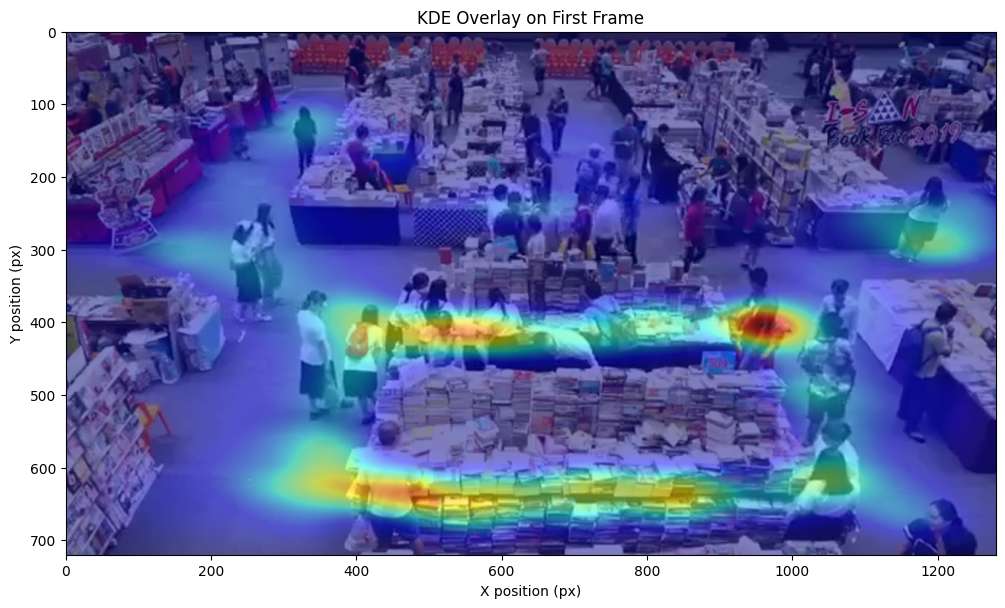

บันทึกแล้ว: heatmap_kde_no_bg.png และ heatmap_kde_overlay.png


In [11]:
plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb, extent=[0, FRAME_WIDTH, FRAME_HEIGHT, 0])
plt.imshow(
    density.T,
    cmap="jet",
    extent=[0, FRAME_WIDTH, FRAME_HEIGHT, 0],
    alpha=0.5,
    origin="upper",
    vmin=vmin, vmax=vmax
)
plt.title("KDE Overlay on First Frame")
plt.xlabel("X position (px)")
plt.ylabel("Y position (px)")
plt.savefig("heatmap_kde_overlay.png", dpi=300)
plt.show()

print("บันทึกแล้ว: heatmap_kde_no_bg.png และ heatmap_kde_overlay.png")